In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Variáveis

In [2]:
endereco_arquivos = Path("C:\\Users\\claud\\OneDrive\\Claudio Bonel-DADOTECA\\Senac\\Python - FATEC\\Dados\\")

# Funções

In [3]:
def exporta_excel (dataframe,endereco_arquivo,nome_arquivo,nome_planilha,endereco_imagem):
    #nome do arquivo
    excel = endereco_arquivo / nome_arquivo

    if (endereco_arquivo.exists()):
        #Se o endereço existir segue com o processo de criação ou append de dados no excel
        escrita = pd.ExcelWriter(excel, engine='xlsxwriter')

        #Adiciona na planilha "Tabela"
        dataframe.to_excel(escrita,sheet_name=nome_planilha, index=False)

        #adiciona na planilha "Gráfico"
        planilha = escrita.sheets[nome_planilha]
        planilha.insert_image('E2', endereco_imagem)

        #fecha o arquivo
        escrita.close()

    else:
        #Se o endereço não existir, envia uma mensagem de erro!
        print('Endereço não existe! Favor verificar!')

    print("Arquivo exportado com sucesso!")

In [4]:
def enviar_email (nome_arquivo_anexo,endereco_arquivo_anexo,subject):
    #bibliotecas para envio de email com anexo
    import smtplib #biblioteca para envio de um arquivo
    from email.mime.multipart import MIMEMultipart #biblioteca para configuração da estrutura do email
    from email.mime.text import MIMEText #biblioteca pra configuração do corpo do email
    from email.mime.base import MIMEBase #biblioteca para configuraçã do anexo
    from email import encoders #PAra envio do anexo
    #Definindo remetente e destinatários
    app_password = "uljgjirvbygiwmbm"
    remetente = "senacpython@gmail.com" #senha: @A12345678
    destinatario = "claudiobonel@gmail.com"
    #com_copia = "contato@dadoteca.com.br"
    #com_copia_oculta = "contato@profclaudiobonel.com.br"

    #Estruturando o email
    msg = MIMEMultipart() 
    msg["From"] = remetente 
    msg["To"] = destinatario 
    #msg["Cc"] = com_copia
    #msg["Cco"] = com_copia_oculta
    msg["Subject"] = subject
    body = """ 
        Boa noite! 

        Em anexo, envio o arquivo atualizado.

        Qq dúvida, entrar em contato.

        At.te.
        Claudio Bonel
        """
    msg.attach(MIMEText(body, 'plain')) 

    #Denifindo o anexo
    nome_arquivo = nome_arquivo_anexo 
    endereco_arquivo = open(endereco_arquivo_anexo, "rb") #rb é o modo como o arquivo será aberto. Leitura e escrita, nesse caso
    anexo = MIMEBase('application', 'octet-stream') #Os argumentos são relativos a anexos do tipos documentos.
    anexo.set_payload((endereco_arquivo).read()) 
    encoders.encode_base64(anexo) 

    #Definindo a nomenclatura do anexo.
    anexo.add_header('Content-Disposition', "attachment; filename= %s" % nome_arquivo) 
    msg.attach(anexo) 

    #Definindo os parâmetros de envio
    try:
        envio = smtplib.SMTP('smtp.gmail.com', 587) 
        envio.starttls() 
        envio.login(remetente, app_password) 
        tipo_mensagem = msg.as_string()
        #envio.sendmail(msg['From'], msg['To'].split(",") + msg["Cc"].split(",") + msg["Cco"].split(","), tipo_mensagem) 
        envio.sendmail(msg['From'], msg['To'].split(","), tipo_mensagem) 
        envio.quit() 
        print("E-mail enviado com sucesso!")
    except:
        print("Algo de errado aconteceu. Favor verificar")
    

# Coletando dados de município

In [5]:
municipio = pd.read_html('https://ibge.gov.br/explica/codigos-dos-municipios.php',match="Municípios do Rio de Janeiro")[0]
municipio = municipio.rename(columns={"Municípios do Rio de Janeiro":"municipios","Códigos":"mcirc"})
municipio

,municipios,mcirc
0,Angra dos Reis,3300100
1,Aperibé,3300159
2,Araruama,3300209
3,Areal,3300225
4,Armação dos Búzios,3300233
...,...,...
87,Três Rios,3306008
88,Valença,3306107
89,Varre-Sai,3306156
90,Vassouras,3306206


# Coletando dados de ocorrências e relacionando com municípios

In [6]:
#Coleta de ocorrências
ocorrencias = pd.read_csv("C:\\Users\\claud\\OneDrive\\Claudio Bonel-DADOTECA\\Senac\\Python - FATEC\\Dados\\ocorrencias.csv")

#relacionando ocorrências com município
df_ocorrencias = pd.merge(ocorrencias,municipio,on=["mcirc","mcirc"],how="inner")

#visualiza o resultado do relacionamento sem filtros
df_ocorrencias = df_ocorrencias.query("ano>=2021 and ocorrencias == 'ameaca'")

# Medidas estatísticas

In [7]:
#Define a criação do DataFrame somente com município e qtde (Somada)
df_ocorrencias_munic = df_ocorrencias[["municipios","qtde"]]
df_ocorrencias_munic = pd.DataFrame(df_ocorrencias_munic.groupby(["municipios"])["qtde"].sum())

#Top 15
df_ocorrencias_munic = df_ocorrencias_munic.nlargest(15,"qtde")

#Criando lista de análise de dados
lista_munic = []

#Média
media = round(np.average(df_ocorrencias_munic["qtde"]),2)
dados = ("Média",media)
lista_munic.append(dados)

#Quantiles
quantile_25 = np.quantile(df_ocorrencias_munic["qtde"],q=0.25)
dados = ("Quantil 25%",quantile_25)
lista_munic.append(dados)

quantile_50 = np.quantile(df_ocorrencias_munic["qtde"],q=0.5)
dados = ("Quantil 50%",quantile_50)
lista_munic.append(dados)

quantile_75 = np.quantile(df_ocorrencias_munic["qtde"],q=0.75)
dados = ("Quantil 75%",quantile_75)
lista_munic.append(dados)

#amplitude
amplitude = np.max(df_ocorrencias_munic["qtde"]) - np.min(df_ocorrencias_munic["qtde"])
dados = ("Amplitude",amplitude)
lista_munic.append(dados)

#Variacia
variancia = round(np.var(df_ocorrencias_munic["qtde"]),2)
dados = ("Variância",variancia)
lista_munic.append(dados)

#Criando datafram do top 15
df_top15_municipios_analise_dados = pd.DataFrame(lista_munic)

#Renomeia Colunas
df_top15_municipios_analise_dados = df_top15_municipios_analise_dados.rename(columns={0:"Análise",1:"Valor"})

#Visualiza análise dos dados
df_top15_municipios_analise_dados

,Análise,Valor
0,Média,3837.60
1,Quantil 25%,1387.00
2,Quantil 50%,1731.00
3,Quantil 75%,2364.00
4,Amplitude,28346.00
5,Variância,47832637.31


# Visualizando o Rank de municípios Top 15, exportando para o Excel e enviando por email

Arquivo exportado com sucesso!
E-mail enviado com sucesso!


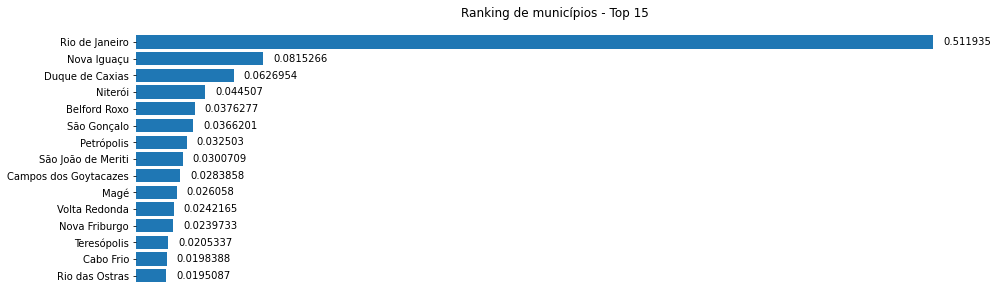

In [8]:
#tamanho do gráfico
plt.figure(figsize=(15, 5))

#Criando a coluna influencia
df_ocorrencias_munic["influencia"] = df_ocorrencias_munic["qtde"] / np.sum(df_ocorrencias_munic["qtde"])

#Reiniciando índice, para utilizar município no gráfico
df_ocorrencias_munic = df_ocorrencias_munic.reset_index()

#ordenar valores
df_ocorrencias_munic = df_ocorrencias_munic.sort_values(by="influencia")

#plotagem do gráfico
rank_municipio = plt.barh("municipios","influencia",data=df_ocorrencias_munic)

#título do gráfico
plt.title("Ranking de municípios - Top 15") 

#remove o eixo X
ax = plt.gca() #get current axis: método para acionar um eixo específico
ax.get_xaxis().set_visible(False) #remove o eixo X

#rótulos de dados
plt.bar_label(rank_municipio, padding=10)

#removendo borda
plt.box(False) 

#exportação da imagem
endereco_rk_municipios_jpg = endereco_arquivos / 'rk_municipios.jpg'
plt.savefig(endereco_rk_municipios_jpg)

#Exporta arquivo
exporta_excel(df_top15_municipios_analise_dados,endereco_arquivos,"municipios.xlsx","analise",endereco_rk_municipios_jpg)

#Enviar email
enviar_email("municipios.xlsx",
             endereco_arquivos/ "municipios.xlsx",
            "Análise de dados para Municípios")

#Retornando gráfico
plt.show(rank_municipio)